we start with 3204769 transcripts, only 532080 transcripts that were assigned to our polygons
from xenium we know that they detected 216323 cells, we detected 147344 or 83947 after processing (including filtering of 4489, because polygon was not uniquely mapped to a cell)

In [1]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-09-01 17:59:56.641376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gdf = gpd.read_file('../data/xenium/stardist_buffered_07.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

id                                           geometry
0            ID_1  POLYGON ((2064.585 346.259, 2064.443 347.150, ...
1            ID_2  POLYGON ((2948.857 2708.953, 2948.857 2708.953...
2            ID_3  POLYGON ((2913.311 3155.884, 2913.176 3156.081...
3            ID_4  POLYGON ((3070.291 3509.373, 3070.743 3508.136...
4            ID_5  POLYGON ((2971.103 3292.006, 2970.909 3292.596...
...           ...                                                ...
216348  ID_216349  POLYGON ((27885.864 21588.620, 27885.866 21588...
216349  ID_216350  POLYGON ((28879.943 21223.216, 28879.438 21223...
216350  ID_216351  POLYGON ((27610.110 20999.249, 27609.944 20999...
216351  ID_216352  POLYGON ((28838.589 20801.128, 28838.483 20801...
216352  ID_216353  POLYGON ((28713.604 22061.967, 28713.751 22062...

[216353 rows x 2 columns]

In [3]:
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [4]:
adata_df = adata.to_df()

In [5]:
df_tissue_positions = adata_df
df_tissue_positions['index']=df_tissue_positions.index

In [6]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [7]:
gdf.crs = None

In [8]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [9]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [10]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [11]:
barcodes_in_one_polygon.shape

(1942937, 546)

In [12]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [14]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [15]:
filtered_adata = adata[filtered_obs_mask,:]

In [16]:
filtered_adata

View of AnnData object with n_obs × n_vars = 1010025 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [17]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 1010025
Length of barcodes_in_one_polygon: 1010025


In [18]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1402)', '(0, 1415)', '(0, 1425)', '(0, 1429)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1402)    (0, 1402)
(0, 1415)    (0, 1415)
(0, 1425)    (0, 1425)
(0, 1429)    (0, 1429)
Name: index, dtype: object


In [19]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [20]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1415)    sample1   5977.914968  20058.317955   5987.326733  20067.729720   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 112)  sample1  26693.209086   7794.788543  26702.620851   7804.200308   
(2201, 119)  sample1  26693.209086   7860.670896  26702.620851   7870.082661   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1415)     5982.620851  20063.023838                  1   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 112)  26697.914968   7799.494426                  2   
(2201, 119)  26697.914968   7865.376779                  2   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1402)                   1.098612             2            1.098612   
(0, 1415)                   0.693147             1            0.693147   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 112)                 1.098612             2            1.098612   
(2201, 119)                 1.098612             2            1.098612   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1402)                         100.0                        100.0   
(0, 1415)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 112)                       100.0                        100.0   
(2201, 119)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1402)                          100.0       

In [21]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [22]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [23]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 144668 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [24]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [25]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [26]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [27]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


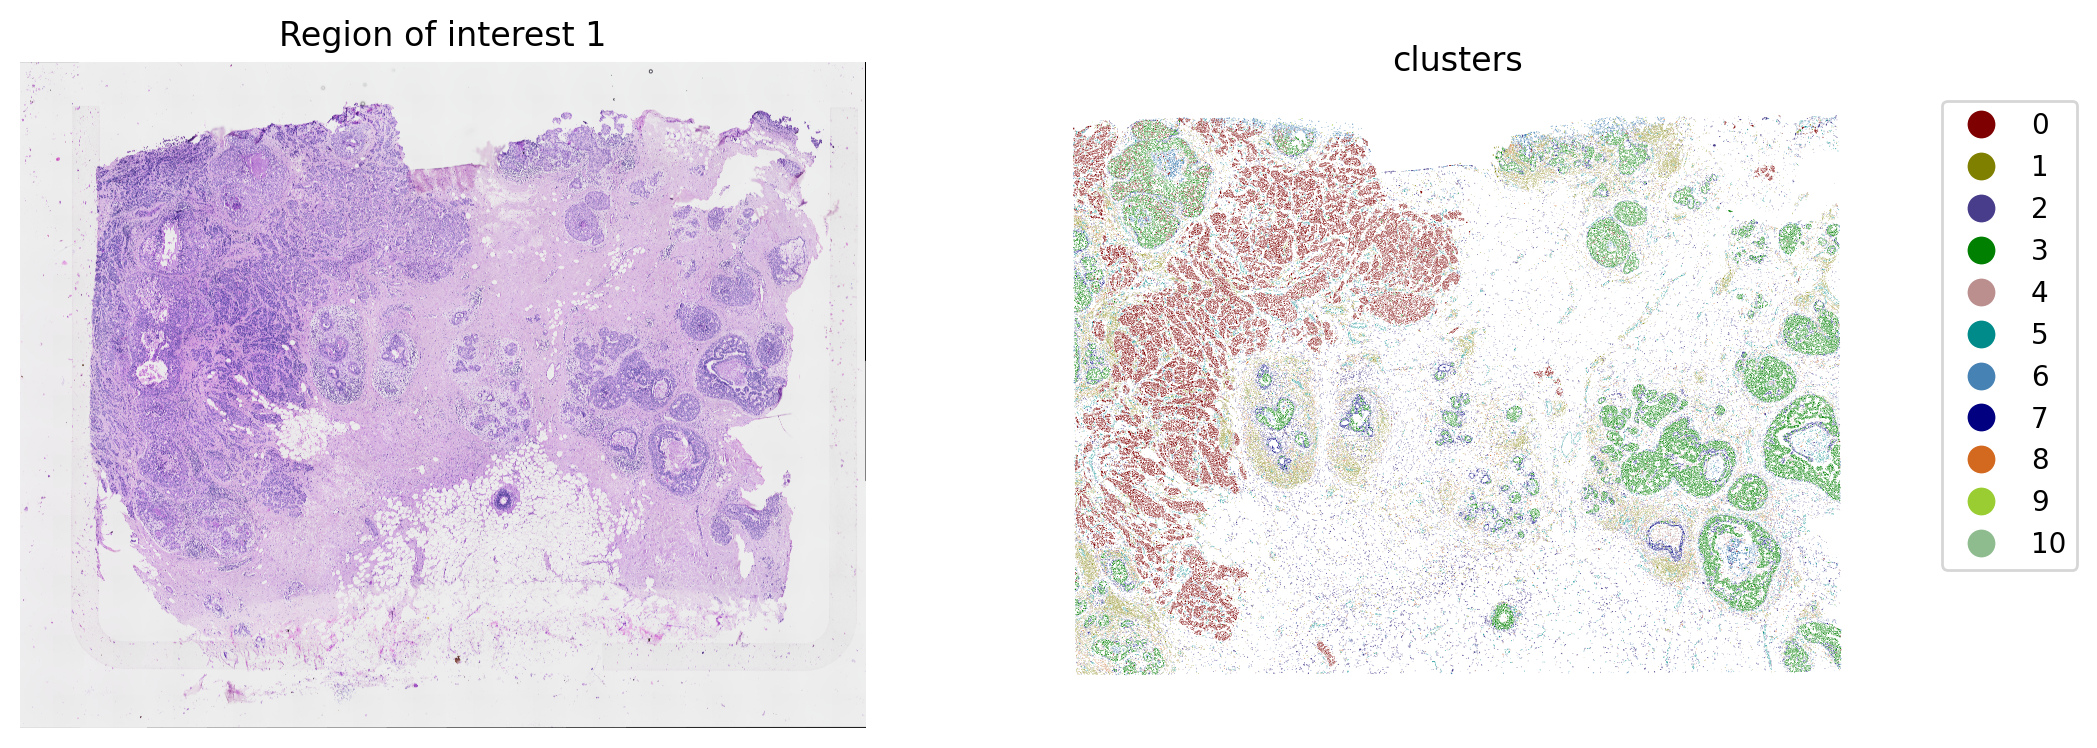

In [28]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [27]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

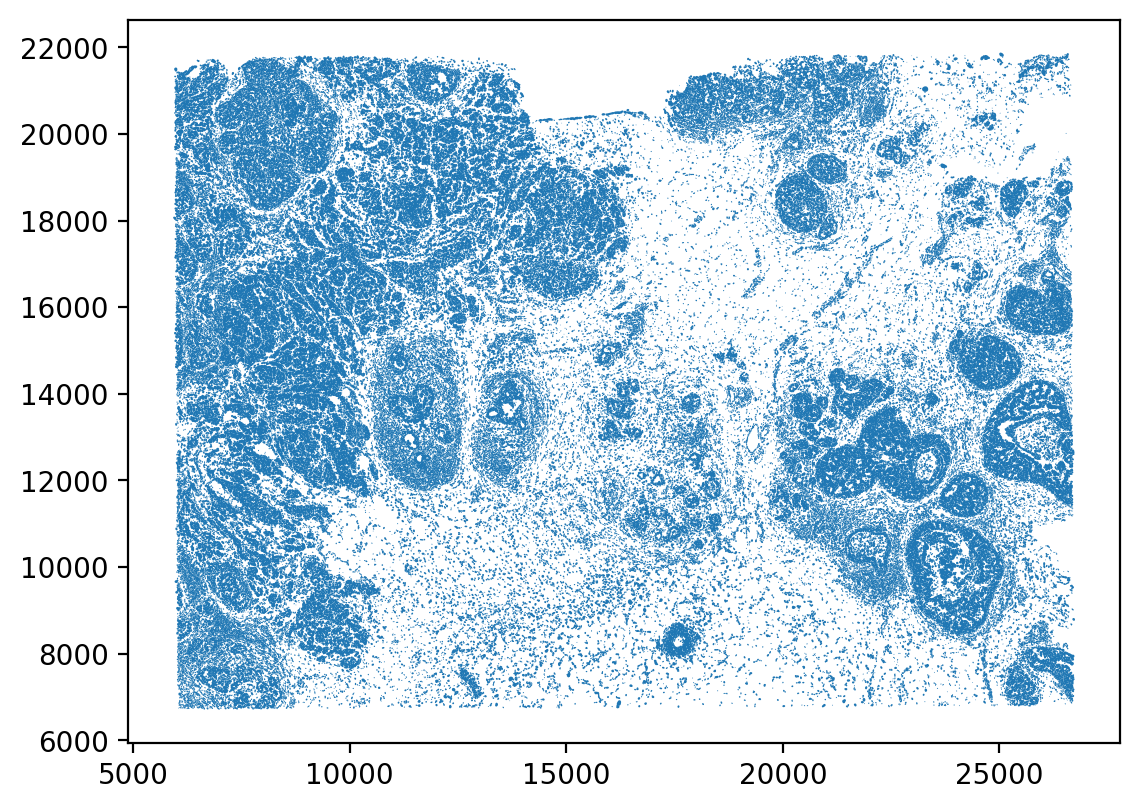

In [28]:
merged_gdf.plot()

In [29]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [30]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [31]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [32]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [33]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [34]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [35]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

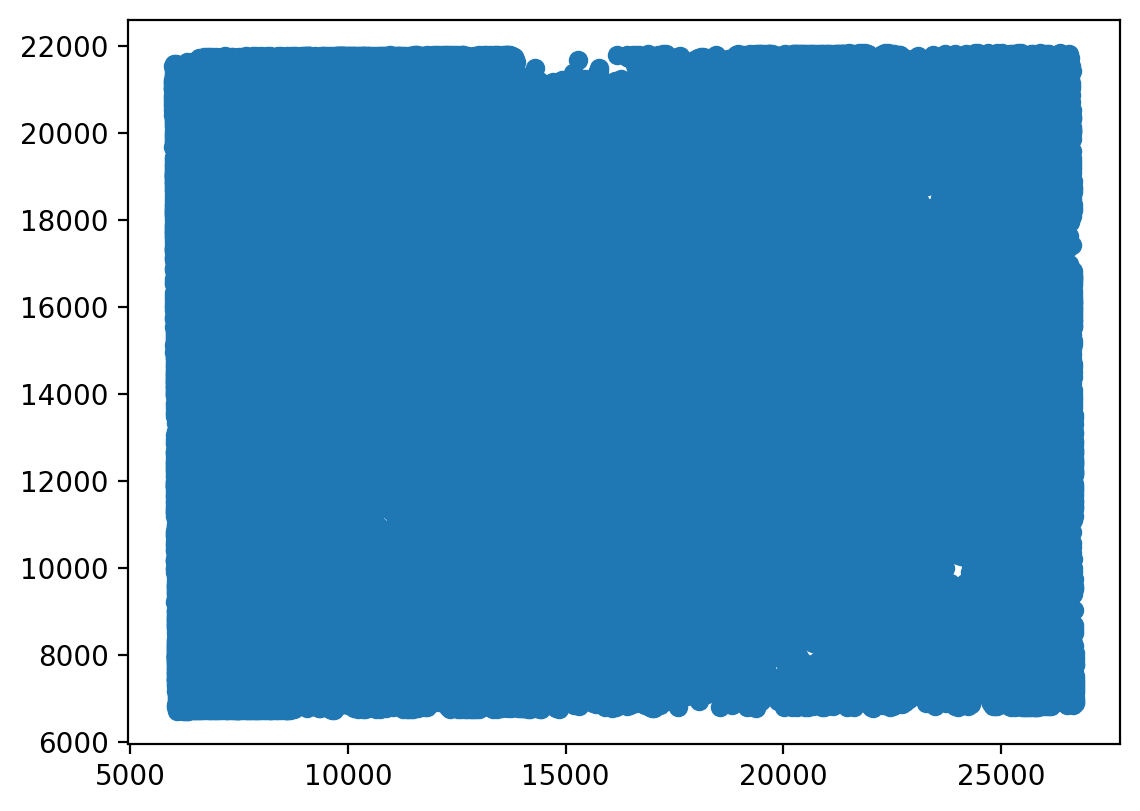

In [38]:
cells_gdf.plot()

In [36]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

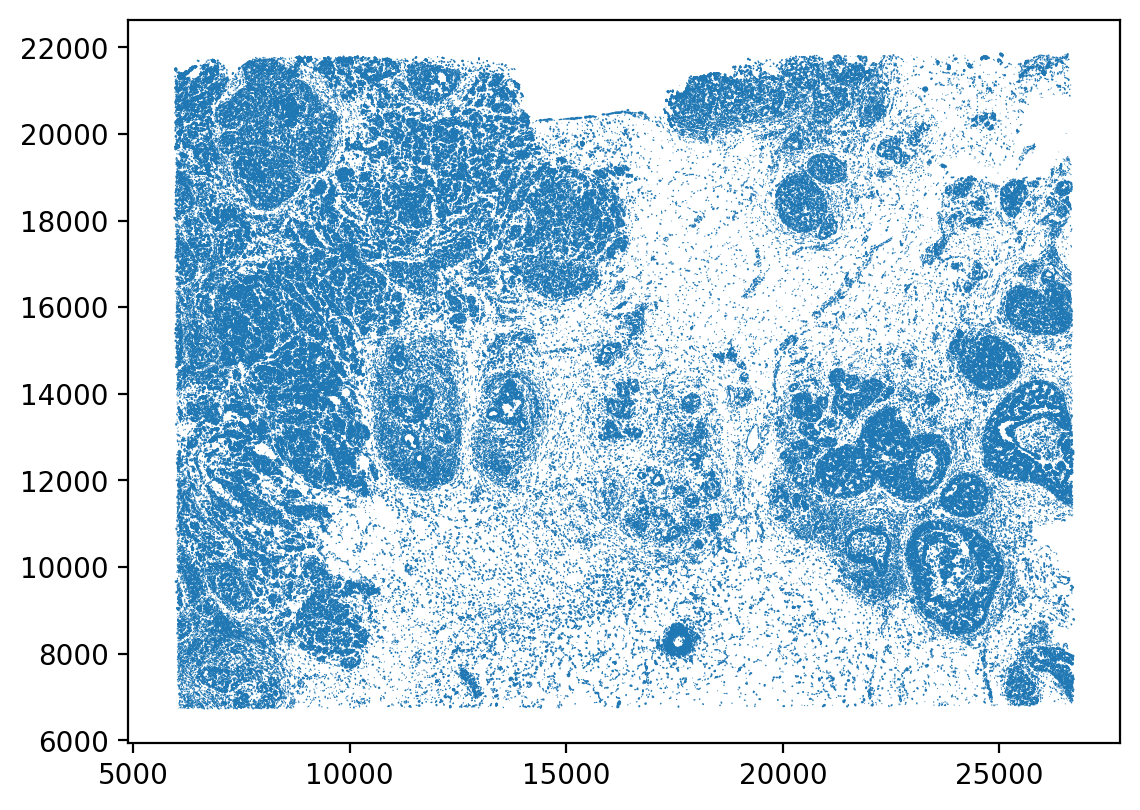

In [37]:
joined.plot()

In [38]:
joined

id                                           geometry   
6224      ID_6225  POLYGON ((7163.346 6833.900, 7162.935 6830.848...  \
6224      ID_6225  POLYGON ((7163.346 6833.900, 7162.935 6830.848...   
6231      ID_6232  POLYGON ((6290.217 6963.757, 6290.197 6962.958...   
6231      ID_6232  POLYGON ((6290.217 6963.757, 6290.197 6962.958...   
6234      ID_6235  POLYGON ((7213.817 6737.685, 7213.411 6736.306...   
...           ...                                                ...   
215214  ID_215215  POLYGON ((24354.005 21262.831, 24353.769 21262...   
215215  ID_215216  POLYGON ((25919.365 21783.603, 25919.673 21783...   
215217  ID_215218  POLYGON ((26647.291 21117.082, 26647.275 21117...   
215218  ID_215219  POLYGON ((25619.447 21610.830, 25619.467 21610...   
215220  ID_215221  POLYGON ((24869.681 21161.179, 24869.703 21161...   

        index_right  cell_id  x_centroid   y_centroid  transcript_counts   
6224        42284.0  42285.0  399.355255  5437.458716              592.0  \
6224        42276.0  42277.0  388.584213  5427.913232               83.0   
6231        42968.0  42969.0   86.363805  5391.260303               90.0   
6231        42966.0  42967.0   82.964026  5382.626245              173.0   
6234         3242.0   3243.0  418.956461  5470.879736               26.0   
...             ...      ...         ...          ...                ...   
215214          NaN      NaN         NaN          NaN                NaN   
215215          NaN      NaN         NaN          NaN                NaN   
215217          NaN      NaN         NaN          NaN                NaN   
215218          NaN      NaN         NaN          NaN                NaN   
215220          NaN      NaN         NaN          NaN                NaN   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         592.0  \
6224                     0.0                      0.0          83.0   
6231                     0.0                      0.0          90.0   
6231                     0.0                      0.0         173.0   
6234                     0.0                      0.0          26.0   
...                      ...                      ...           ...   
215214                   NaN                      NaN           NaN   
215215                   NaN                      NaN           NaN   
215217                   NaN                      NaN           NaN   
215218                   NaN                      NaN           NaN   
215220                   NaN                      NaN           NaN   

         cell_area  nucleus_area  x_location_transformed   
6224    398.142656    147.525469             7135.520510  \
6224     48.362344     24.700469             7105.795014   
6231    103.949688     32.873750             6274.834701   
6231    179.405781     55.813125             6265.376854   
6234    196.384531     35.402500             7189.830063   
...            ...           ...                     ...   
215214         NaN           NaN                     NaN   
215215         NaN           NaN                     NaN   
215217         NaN           NaN                     NaN   
215218         NaN           NaN                     NaN   
215220         NaN           NaN                     NaN   

        y_location_transformed  
6224               6822.211526  
6224               6848.297267  
6231               6944.968708  
6231               6968.648654  
6234               6730.636591  
...                        ...  
215214                     NaN  
215215                     NaN  
215217                     NaN  
215218                     NaN  
215220                     NaN  

[190354 rows x 14 columns]

In [39]:
filtered_joined = joined[~joined['index_right'].isna()]

In [40]:
filtered_joined

id                                           geometry   
6224      ID_6225  POLYGON ((7163.346 6833.900, 7162.935 6830.848...  \
6224      ID_6225  POLYGON ((7163.346 6833.900, 7162.935 6830.848...   
6231      ID_6232  POLYGON ((6290.217 6963.757, 6290.197 6962.958...   
6231      ID_6232  POLYGON ((6290.217 6963.757, 6290.197 6962.958...   
6234      ID_6235  POLYGON ((7213.817 6737.685, 7213.411 6736.306...   
...           ...                                                ...   
215139  ID_215140  POLYGON ((24871.329 21727.959, 24871.877 21727...   
215150  ID_215151  POLYGON ((26544.815 21115.007, 26544.523 21114...   
215162  ID_215163  POLYGON ((25919.942 21217.522, 25919.298 21217...   
215167  ID_215168  POLYGON ((26173.389 21463.800, 26173.478 21464...   
215172  ID_215173  POLYGON ((24183.657 20772.593, 24183.745 20772...   

        index_right   cell_id   x_centroid   y_centroid  transcript_counts   
6224        42284.0   42285.0   399.355255  5437.458716              592.0  \
6224        42276.0   42277.0   388.584213  5427.913232               83.0   
6231        42968.0   42969.0    86.363805  5391.260303               90.0   
6231        42966.0   42967.0    82.964026  5382.626245              173.0   
6234         3242.0    3243.0   418.956461  5470.879736               26.0   
...             ...       ...          ...          ...                ...   
215139     150982.0  150983.0  6879.694141    47.338940               51.0   
215150     166601.0  166602.0  7482.108398   267.412054              320.0   
215162     150650.0  150651.0  7263.995410   225.493784              228.0   
215167     150572.0  150573.0  7360.965967   142.234133              362.0   
215172     151067.0  151068.0  6629.117627   396.159558              463.0   

        control_probe_counts  control_codeword_counts  total_counts   
6224                     0.0                      0.0         592.0  \
6224                     0.0                      0.0          83.0   
6231                     0.0                      0.0          90.0   
6231                     0.0                      0.0         173.0   
6234                     0.0                      0.0          26.0   
...                      ...                      ...           ...   
215139                   0.0                      0.0          51.0   
215150                   0.0                      0.0         320.0   
215162                   0.0                      0.0         228.0   
215167                   0.0                      0.0         362.0   
215172                   0.0                      0.0         463.0   

         cell_area  nucleus_area  x_location_transformed   
6224    398.142656    147.525469             7135.520510  \
6224     48.362344     24.700469             7105.795014   
6231    103.949688     32.873750             6274.834701   
6231    179.405781     55.813125             6265.376854   
6234    196.384531     35.402500             7189.830063   
...            ...           ...                     ...   
215139   86.158125     18.288281            24870.625046   
215150  626.949375     40.008437            26528.942205   
215162  421.578750     17.927031            25929.029622   
215167  581.251250     75.049688            26194.379494   
215172  585.134688     54.322969            24186.738374   

        y_location_transformed  
6224               6822.211526  
6224               6848.297267  
6231               6944.968708  
6231               6968.648654  
6234               6730.636591  
...                        ...  
215139            21720.462413  
215150            21123.791604  
215162            21236.057889  
215167            21466.145038  
215172            20758.585122  

[165396 rows x 14 columns]

<Axes: >

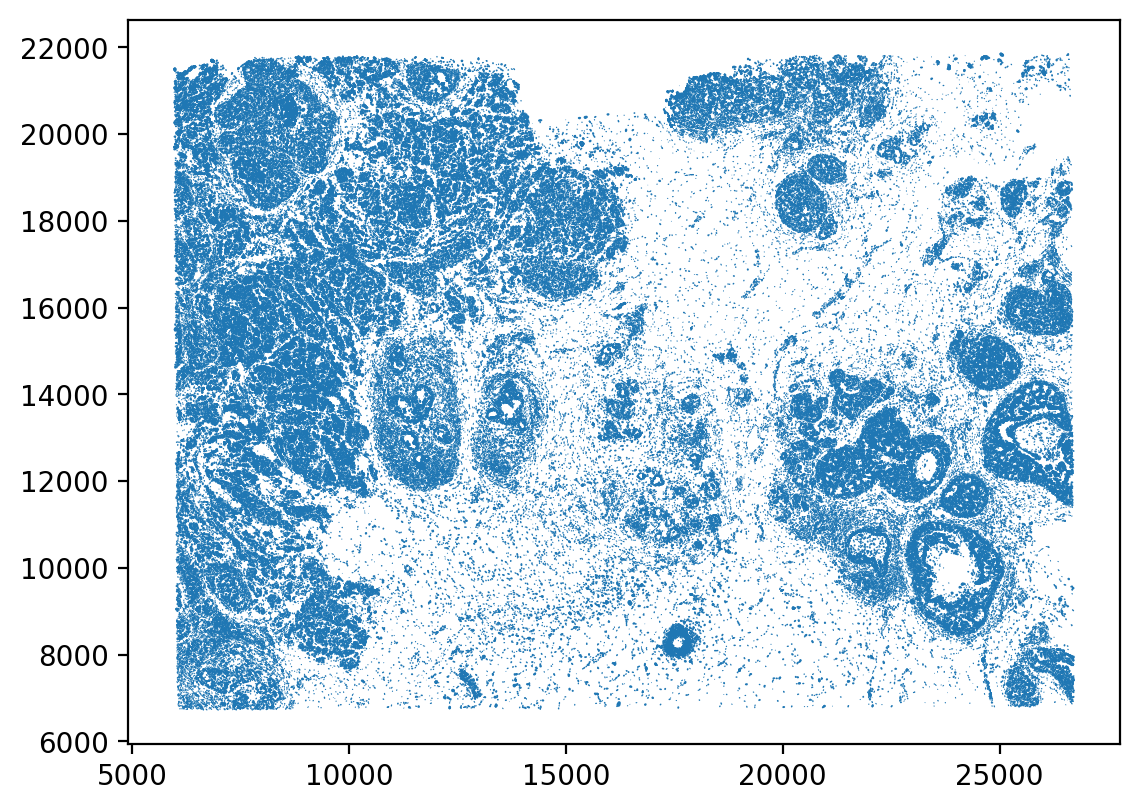

In [41]:
filtered_joined.plot()

In [42]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   
0       ID_100002  POLYGON ((23746.551 11053.089, 23746.070 11053...  \
1       ID_100005  POLYGON ((21817.637 11326.493, 21817.538 11326...   
2       ID_100007  POLYGON ((23111.313 12548.267, 23111.548 12548...   
3       ID_100008  POLYGON ((22288.151 10858.401, 22288.139 10858...   
4       ID_100010  POLYGON ((22746.027 13354.628, 22745.947 13354...   
...           ...                                                ...   
119705   ID_99990  POLYGON ((21572.976 13541.121, 21574.299 13538...   
119706   ID_99991  POLYGON ((23360.886 12946.755, 23361.244 12947...   
119707   ID_99992  POLYGON ((23213.333 14018.254, 23213.401 14016...   
119708   ID_99995  POLYGON ((23862.224 11414.949, 23862.023 11413...   
119709   ID_99999  POLYGON ((21473.824 11155.313, 21474.051 11155...   

                                cell_id  
0                              144585.0  
1                              131974.0  
2       11425.0,11427.0,11426.0,11428.0  
3                              145665.0  
4                              141210.0  
...                                 ...  
119705                         128380.0  
119706                         140498.0  
119707                         141376.0  
119708                         143461.0  
119709                         131635.0  

[119710 rows x 3 columns]

In [43]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 30662


In [44]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry   cell_id
0       ID_100002  POLYGON ((23746.551 11053.089, 23746.070 11053...  144585.0
1       ID_100005  POLYGON ((21817.637 11326.493, 21817.538 11326...  131974.0
3       ID_100008  POLYGON ((22288.151 10858.401, 22288.139 10858...  145665.0
4       ID_100010  POLYGON ((22746.027 13354.628, 22745.947 13354...  141210.0
5       ID_100011  POLYGON ((21358.014 12160.330, 21358.048 12160...  133954.0
...           ...                                                ...       ...
119705   ID_99990  POLYGON ((21572.976 13541.121, 21574.299 13538...  128380.0
119706   ID_99991  POLYGON ((23360.886 12946.755, 23361.244 12947...  140498.0
119707   ID_99992  POLYGON ((23213.333 14018.254, 23213.401 14016...  141376.0
119708   ID_99995  POLYGON ((23862.224 11414.949, 23862.023 11413...  143461.0
119709   ID_99999  POLYGON ((21473.824 11155.313, 21474.051 11155...  131635.0

[89048 rows x 3 columns]

In [45]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

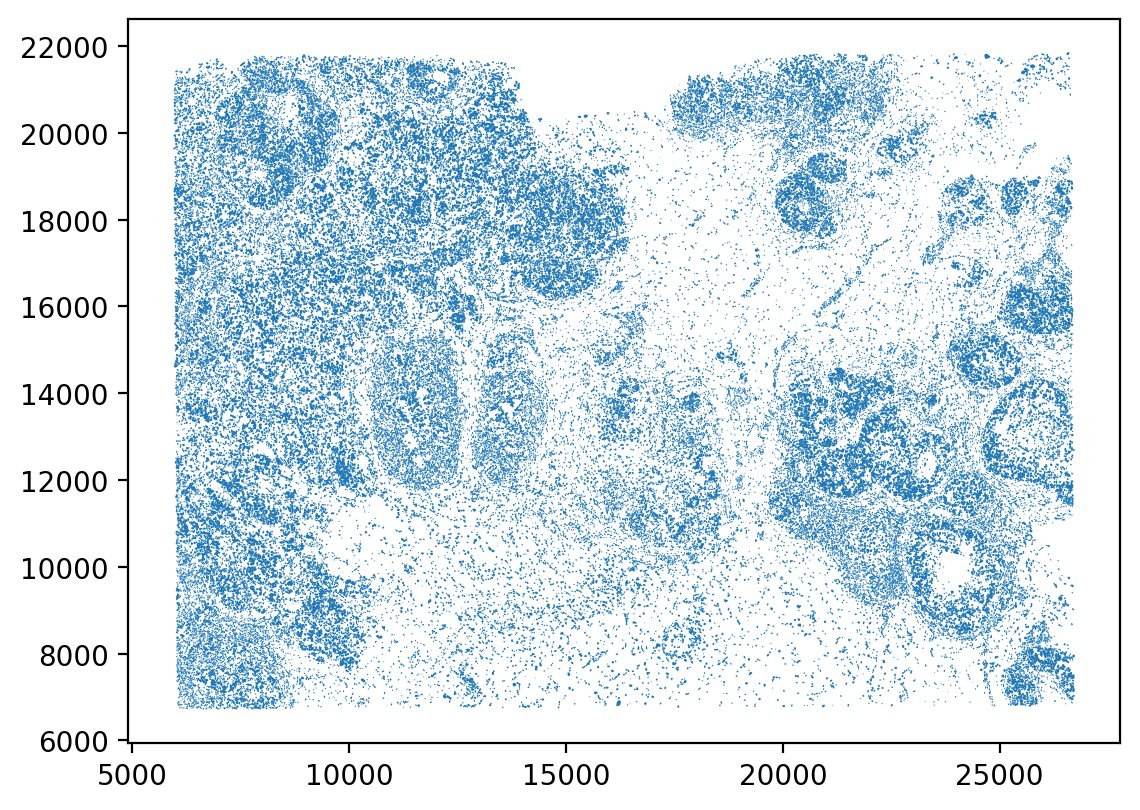

In [46]:
filtered_gdf.plot()

In [47]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/filtered_gdf_stardist_buffered.geojson", driver='GeoJSON')

In [48]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 144668 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [49]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [50]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 89048 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_stardist_buffered07_adata.h5ad")
# IMPORTANT you will need this as ADATA